<a href="https://colab.research.google.com/github/DilsharaHerath/Diffusion-model-performance-for-Caltech256-dataset/blob/main/diffusion_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset


In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt

train = torchvision.datasets.Caltech256(root=".", download=True)
print(train)
# show_images(data)

Downloading...
From (original): https://drive.google.com/uc?id=1r6o0pSROcV1_VwT4oSjA2FBUSCWGuxLK
From (redirected): https://drive.usercontent.google.com/download?id=1r6o0pSROcV1_VwT4oSjA2FBUSCWGuxLK&confirm=t&uuid=ebe8ed58-cad5-4978-a42c-2945892baf5c
To: /content/caltech256/256_ObjectCategories.tar
100%|██████████| 1.18G/1.18G [00:21<00:00, 55.6MB/s]


Dataset Caltech256
    Number of datapoints: 30607
    Root location: ./caltech256


In [2]:
print('train: ', train)

train:  Dataset Caltech256
    Number of datapoints: 30607
    Root location: ./caltech256


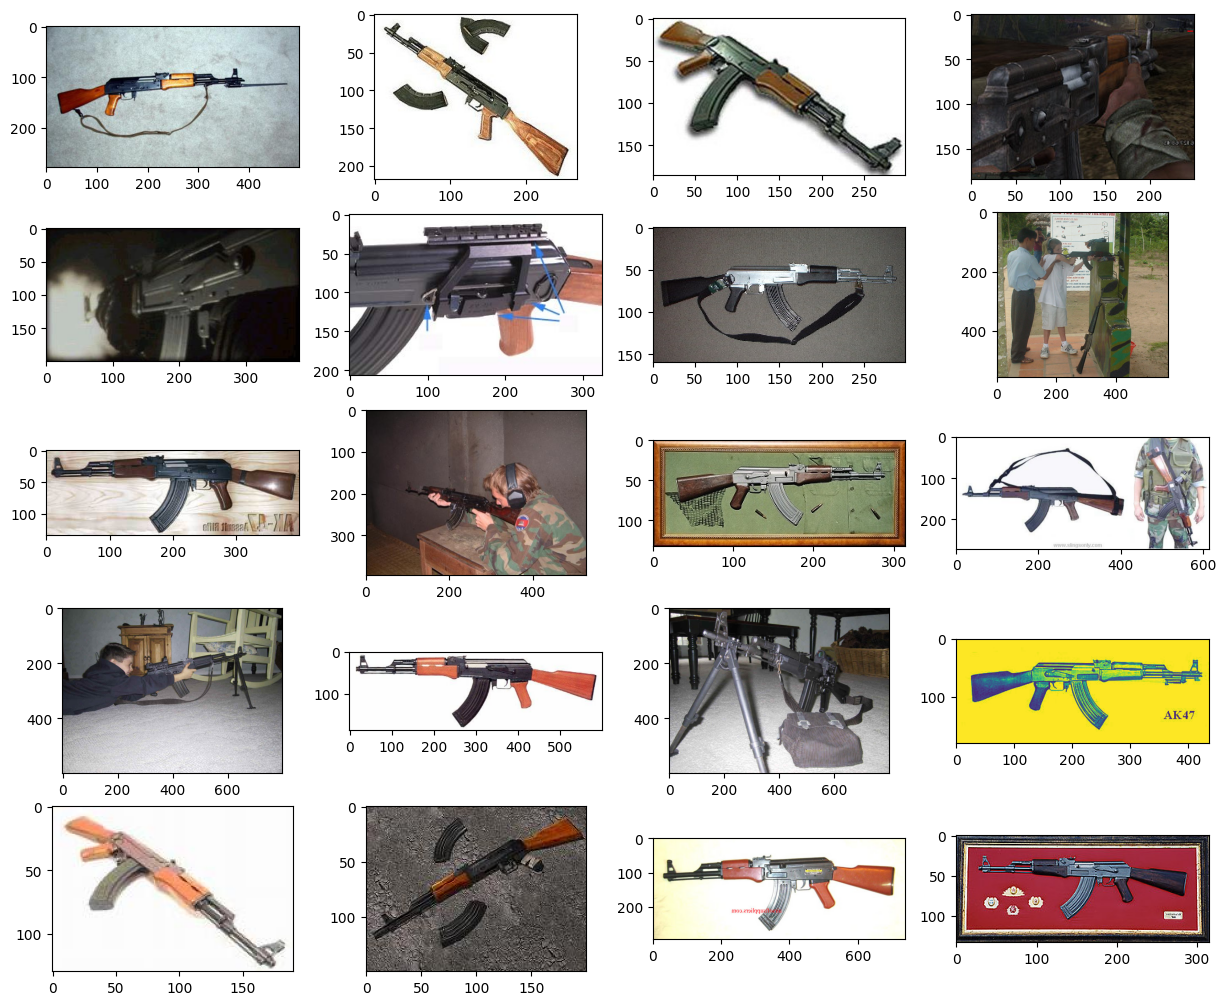

In [3]:
def show_images(data, num_samples=20, cols=4):
  plt.figure(figsize=(15,15))
  for i, img in enumerate(data):
    if i==num_samples:
      break
    plt.subplot(int(num_samples/cols) + 1, cols, i+1)
    plt.imshow(img[0])

show_images(train)

# Building Diffusion Model

## Step 1 - The Forward Process = Noise Scheduler

In [5]:
import torch.nn.functional as F

def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
  return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
  '''
  Returns a specific index t of a passed list of values vals while considering the batch dimension
  '''
  batch_size = t.shape[0]
  out = vals.gather(-1, t.cpu())
  return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, device='cpu'):
  '''
  Takes an image and a timestep as input and returns the noisy version of it
  '''
  noise = torch.randn_like(x_0)
  sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
  sqrt_one_minus_alphas_cumprod_t = get_index_from_list(sqrt_one_minus_alphas_cumprod, t, x_0.shape)

  # Mean + Variance
  return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
  +sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)

# Define Beta Schedule
T = 300
betas = linear_beta_schedule(timesteps=T)

# Pre-calculate different terms for closed form
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)  # cumulative product of elements
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1,0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas* (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)